(1,)
(3571,)
Train for 1400 steps, validate for 50 steps
Epoch 1/10
1400/1400 [==============================] - 68s 49ms/step - loss: 15.3513 - val_loss: 11.2438
Epoch 2/10
1400/1400 [==============================] - 65s 47ms/step - loss: 13.4105 - val_loss: 10.0202
Epoch 3/10
1400/1400 [==============================] - 67s 48ms/step - loss: 12.2355 - val_loss: 9.3328
Epoch 4/10
1400/1400 [==============================] - 65s 47ms/step - loss: 11.5260 - val_loss: 8.9768
Epoch 5/10
1400/1400 [==============================] - 64s 46ms/step - loss: 11.1058 - val_loss: 8.7034
Epoch 6/10
1400/1400 [==============================] - 63s 45ms/step - loss: 10.8173 - val_loss: 8.5273
Epoch 7/10
1400/1400 [==============================] - 61s 44ms/step - loss: 10.5986 - val_loss: 8.4017
Epoch 8/10
1400/1400 [==============================] - 62s 44ms/step - loss: 10.4283 - val_loss: 8.3007
Epoch 9/10
1400/1400 [==============================] - 66s 47ms/step - loss: 10.2935 - val_loss: 8.2

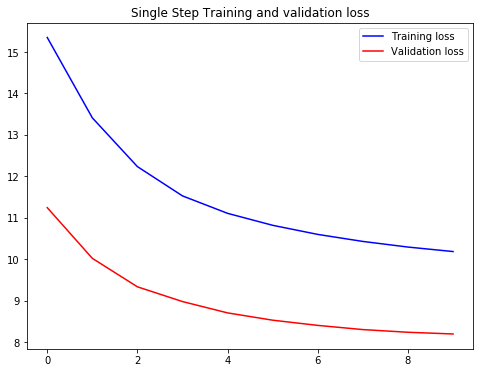

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec  3 21:22:50 2019

@author: 10253
"""

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)     #初始化设置，应该是展示图片大小

mpl.rcParams['axes.grid'] = False

import tushare as ts
import matplotlib.pyplot as plt 

df= ts.get_k_data('399300',ktype='D',start='2005-01-04')      ##这是沪深300的训练
#df= ts.get_k_data('000002',ktype='D',start='2005-01-04') 



zero=np.array([0])
#print(zero.shape)


rt=np.diff(np.array(df['close']))

#print(rt.shape)

rt=np.hstack((zero,rt))

df.insert(5, 'Diff_C', rt)
moving_avg = df['Diff_C'].rolling(window=5).mean(center=True)
MV=moving_avg[2:len(rt)-2]
zeros=np.zeros((4))
MV=np.hstack((zeros,MV))
df.insert(6, 'MV', MV) 
df=df[1000:]
features_considered=['MV']
features = df[features_considered]                       
features.index = df['date']        #在前面加一列时间

dataset = features.values
TRAIN_SPLIT = (len(df)*7)//10      #first 70% of the rows in dataset will be the training dataset
tf.random.set_seed(13)     # 保持random selection每次都一样
EVALUATION_INTERVAL = 1400       #原来是200
EPOCHS = 10       #1个epoch等于使用训练集中的全部样本训练一次，通俗的讲epoch的值就是整个数据集被轮几次。
BATCH_SIZE = 256           #训练的小批次, iteration=TRAIN_SPLIT/256
BUFFER_SIZE = 10000       #缓存容量 
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):         
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)             #就是在取过去天数的样本时，是间隔着几天取的，这样可以减少训练时间
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])                #就是说，这里可以规定只预测后面某一天或者是后面好几天
        else:
            labels.append(target[i:i+target_size])               

    return np.array(data), np.array(labels)        #output 出numpy格式的数据

past_history = 35         # 用过去50天的数据，本来是720
future_target = 0            #本来是72  预测12天后的数据，或者是下一天到12天后的数据   72/6=12
STEP = 1                    #本来是6，取过去天数的样本时，是间隔着6天取的，这样可以减少训练时间

#future_target = 1          # 预测12天后的数据，或者是下一天到12天后的数据   72/6=12
#STEP = 1                     #取过去天数的样本时，是间隔着6天取的，这样可以减少训练时间


x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))              
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()      #traning data 

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()                        #validation data 


single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(6,
                                           input_shape=x_train_single.shape[-2:]))    #应该是这一层有32 个神经元
single_step_model.add(tf.keras.layers.Dense(1))                         #output layer, 因为预测未来1 期的data, 所以是1个神经元

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')    #这里优化算法用RMSprop而不是Adam 或 Momentum

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,      #EPOCHS = 10  轮10次
                                            steps_per_epoch=EVALUATION_INTERVAL,    #每轮test 200次 data
                                            validation_data=val_data_single, 
                                            validation_steps=50)      #设置验证多少次数据后取平均值作为此epoch训练后的效果 

def plot_train_history(history, title):             #把training lost 和validation loss 表示出来
  loss = history.history['loss']             
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and validation loss')


df= ts.get_k_data('399300',ktype='D',start='2005-01-04')

#df= ts.get_k_data('000002',ktype='D',start='2005-01-04')


zero=np.array([0])

rt=np.diff(np.array(df['close']))

rt=np.hstack((zero,rt))

df.insert(5, 'Diff_C', rt) 
moving_avg = df['Diff_C'].rolling(window=5).mean(center=True)
MV=moving_avg[2:len(rt)-2]
zeros=np.zeros((4))
MV=np.hstack((zeros,MV))
df.insert(6, 'MV', MV) 

features_considered=['MV']

features = df[features_considered]                       
features.index = df['date']        #在前面加一列时间






r1= 0.011582086092540736
r1= 0.000877312082885018
r1= 0
r1= 0
r1= 0
r1= 0
r2= 0.0003646507072094082
r2= -0.011498350537405623
r2= 0
r2= 0
r1= -0.010268256215934125
r2= 0.0016810803743207336
r2= 0
r1= 0
r1= 0
r2= 0.008617227667890364
r2= 0.006933055226144453
r2= 0.03740495462349762
r2= 0.013384579623653543
r2= 0
r1= 0.00016273348865338281
r1= 0
r1= 0
r1= -0.010973772138629812
r2= 0
r2= 0.02577057444832625
r1= -0.003597888735156051
r2= -0.005899155991810744
r1= 0.011611245481822158
r1= 0.0034487717578881847
r1= -0.0013432631478338122
r1= 0.0011957335812608427
r1= -0.002962966783311401
r1= 0
r1= -0.0008382316955708567
r1= 0
r2= 0.0062834535722595345
r2= 0.0036385154856817445
r2= 0.0007510326699211904
r2= 0
r2= 0
r2= 0.016482838034579526
r2= 0
r2= 0.031090117170725618
r2= 0
r2= 0.004651932942183668
r2= -0.026107243371352364
r2= 0
r1= 0
r2= 0
r2= 0.0288599966163481
r1= -0.009312718852013811
r1= 0
r2= 0
r2= 0.0010974384570589229
r2= -0.05132597754548964
r2= 0.013341309993533187
r2= 0
r2= 0.0

r1= 0.007373257819774757
r1= 0
r1= 0.003399454780718771
r1= 0.007368724248913505
r1= -0.004023924966219082
r1= 0
r1= -0.006870811352121029
r1= 0
r1= 0
r2= 0.010159655315353691
r1= 0.007918158313444687
r1= -0.0008589432529759579
r1= 0.00676296523173892
r1= 0.009932530511092946
r1= 0
r1= 0
r1= -0.0047494447986984245
r1= 0.0008411433698399458
r1= 0
r1= 0.001648533602771013
r1= 0.02077761777412042
r1= -0.00018919820167113613
r1= 0
r1= 0
r2= -0.00953305632524891
r1= 0
r2= -0.0029367708802194954
r2= 0
r2= -0.0024351904987648804
r2= 0
r2= 0.0038362821853887338
r2= 0
r2= 0.0007282954107308589
r2= 0.010163760692387324
r2= 0.0156281196342291
r1= 0
r1= 0.00903376575490248
r1= -0.006109753388135969
r1= 0
r1= 0
r1= 0.01242153433923252
r2= -0.0013701616939460657
r2= 0
r1= -0.0025363415180163756
r1= -0.004308911242340985
r1= 0
r1= 0
r1= -0.002400355461118863
r2= 0
r2= 0
r1= 0.0029052465190706755
r1= 0.003570629928150008
r1= 0
r1= 0.0022791336401086866
r1= 0
r1= 0
r1= 0
r1= 0.002246455368601399
r1= -0

r1= -0.0034547931733900977
r1= -0.00514735618885758
r1= 0.01010000332236951
r1= -0.0010195420598766232
r1= 0.0051957248902594734
r1= -0.0053540272518738646
r1= 0.0018396054761516173
r1= 0
r1= 0
r1= 0
r2= 0.003659515770402767
r2= -0.0002866664277780653
r2= -0.0025469579288859875
r2= 0
r1= 0.009824389045806238
r1= 0
r1= 0
r2= -0.0028076864301201034
r2= 0.007073542510068954
r2= -0.00045718042959543264
r2= 0
r2= 0.00128066864383956
r2= 0.0015643434335507243
r2= 0.00014339683640499624
r2= 0.005713972333718994
r2= 0.0038487011937232323
r2= 0
r1= 0.00446067756997316
r1= -0.0036651678611072562
r1= 0
r1= -0.0011286970587331604
r1= 0
trading dates= 563
success to sell= 138
success to buy= 156
负趋势收益= 0.32907344131079164
做多总收益= 0.930926725175896
正趋势做多的次数 253
总体策略日中最大回撤= [-0.05321654]
正趋势日中做多最大亏损= [-0.05132598]
正趋势日平均收益= 0.0006018532838651046
最终复利= 0.3730817799140582
明天收盘价< 3914.0499999999997 概率为 0.5548387096774193
明天请在标准价 3914.0499999999997 挂一个多单，如果触发了标准价,即价格>= 3914.0499999999997 请在收盘价挂一个空单


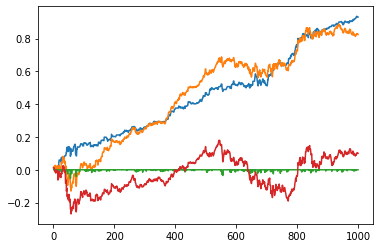

In [3]:
    
 #一阶对称模型4：做多时，如果前一天收盘价小于标准价，就按开盘价交易，如果前一天收盘价大于明天标准价，那就只有触发标准线才做交易

m=0
n=0
p=0
r=0
R=0
s=0

I=0
B=0
RR=[0]
II=[0]
BB=[0]
tt=0
t=0
d=12
d2=0

rr=[0]
maximum_markdown_final=[0]
CR=1
CRR=[0]

day=1000
k=day
#for k in range(3000):
while k<=day and k>0:
    
    if k>0:
        data=np.array(features[-past_history-k:-1-k])
        data2=np.array(features.iloc[-1-k])
        data=np.vstack((data,data2))

        
        t+=1 
        
        tt=np.vstack((tt,t))
        
        
        #print(data2)

        #j=[0,0,0,0,0]
        j=[0]
        
        for i in data:
            i=np.array([i])
            j=np.vstack((j,i))
        #print(j.shape)

        j=j[1:past_history+1]
        #print(j.shape)
        j=[j]
        
        
        
        
        
        
        #data.reshape((240,1))
        #print(data.shape)
        data=tf.convert_to_tensor(j)
        #print(data)



        x=np.array(single_step_model.predict(data))

        #trend=x[0][0]-MV[-1-k]-MV[-2-k]                #预测正负
        
        #trend_real=MV[-k]-MV[-1-k]-MV[-2-k]           #实际正负
        
        #P0=np.array(df['C'])[-7-k]
        #P1=np.array(df['C'])[-6-k]
        #P2=np.array(df['C'])[-5-k]
        #P5=np.array(df['C'])[-2-k]
        #P6=np.array(df['C'])[-1-k]
        
        trend=x[0][0]-MV[-1-k]                #预测正负
        
        trend_real=MV[-k]-MV[-1-k]          #实际正负
        
        
        P0=np.array(df['close'])[-6-k]
        P1=np.array(df['close'])[-5-k]
        P5=np.array(df['close'])[-1-k]
        
        
        
        
        
        #line=P6+P5+P2-P1-P0
        
        line=P5+P1-P0
        
        L=np.array(df['low'])[-k]
        H=np.array(df['high'])[-k]
        
        if trend<0:
            if P5-d2>line and (np.array(df['open'])[-k])-d2>line:
                r1=((np.array(df['close'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
                maximum_markdown=((np.array(df['low'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
            else:
                if L<line<H:
                    r1=((np.array(df['close'])[-k])-(line))/(line)    #r1必须小于0 
                    maximum_markdown=((np.array(df['low'])[-k])-(line))/(line)
                else:
                    r1=0
                    maximum_markdown=0
            print("r1=",r1)
            
            if r1!=0:
                m+=1
                
            
            if r1<0:
                n+=1
            r=r+r1
            R=R+r1
            
        else:
            r1=0
            r=r
            R=R
            maximum_markdown=0
            
            
        
        if trend>0:
            
            
            if P5<line-d and (np.array(df['open'])[-k])<line-d:
                r2=((np.array(df['close'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
                maximum_markdown=((np.array(df['low'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
                
            else:
                if L<line<H:
                    r2=((np.array(df['close'])[-k])-(line))/(line)    #r2必须大于0 
                    maximum_markdown=((np.array(df['low'])[-k])-(line))/(line)
                
                else:
                    r2=0
                    maximum_markdown=0
            print("r2=",r2)
            
            if r2!=0:
                m+=1
                s+=1
            
            if r2>0:
                p+=1
            R=R+r2
        else:
            R=R
            r2=0
            maximum_markdown=0
        
        
        i=((np.array(df['close'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
        I=I+i
        
        b=((np.array(df['close'])[-k])-(np.array(df['close'])[-k-1]))/(np.array(df['close'])[-k-1])
        B=B+b
        
        
        BB=np.vstack((BB,B))
        RR=np.vstack((RR,R))  
        II=np.vstack((II,I))
        
        maximum_markdown_final=np.vstack((maximum_markdown_final,maximum_markdown))
        rr=np.vstack((rr,r2))
        
        if r1!=0:
            CR=CR*(1+r1)
        else:
            CR=CR
        if r2!=0:
            CR=CR*(1+r1)
        else:
            CR=CR
        
        CRR=np.vstack((CRR,(CR-1)*10))
    k=k-1
    
RR=RR[1:]
II=II[1:]
tt=tt[1:]
plt.plot(tt,RR)               
plt.plot(tt,II) 
  
maximum_markdown_final=maximum_markdown_final[1:]        
plt.plot(tt,maximum_markdown_final)  
final_maximum=min(maximum_markdown_final)
rr=rr[1:]
maximum_loss=min(rr) 

     
print("trading dates=",m)
print("success to sell=",n)
print("success to buy=",p)
print('负趋势收益=',r)
print('做多总收益=',R)
print('正趋势做多的次数',s)      
print('总体策略日中最大回撤=',final_maximum)
print('正趋势日中做多最大亏损=',maximum_loss)
print('正趋势日平均收益=',np.mean(rr))
print('最终复利=',CR-1)
#CRR=CRR[1:]
#plt.plot(tt,CRR)
BB=BB[1:]
plt.plot(tt,BB)



data=np.array(features[-past_history:-1])
data2=np.array(features.iloc[-1])
data=np.vstack((data,data2))

j=[0]
        
for i in data:
    i=np.array([i])
    j=np.vstack((j,i))
    

j=j[1:past_history+1]
        
j=[j]
        

data=tf.convert_to_tensor(j)
x=np.array(single_step_model.predict(data))

trend=x[0][0]-MV[-1]                
        
  
P0=np.array(df['close'])[-6]
P1=np.array(df['close'])[-5]
P5=np.array(df['close'])[-1]

line=P5+P1-P0

if trend>0:
    print("明天收盘价>",line,'概率为',p/s)
    
    
    
else:
    print("明天收盘价<",line,'概率为',1-n/(m-s))     #这是沪深300的每日判断
    

if trend>0 and P5<line-d:
    print('前一天收盘价已经小于标准价了，当开盘价也小于标准价',line,"减去12个点,即为",line-12,"时，请在开盘时间做多，同时挂一个收盘的空单")
    
elif trend>0:
    print('明天请在标准价',line,'挂一个多单，如果触发了标准价，请在收盘价挂一个空单')
    
    if P5>=line-d and line>P5:
        print('如果触发了标准价，请按开盘价的价格挂一个多单，如果触发了开盘价的多单，再在收盘挂多一个空单')
    
elif trend<0:
    if P5-d2>line and (np.array(df['open'])[-k])-d2>line:
        print("如果明天开盘价大于",line+d2,'请在开盘时间做多，同时挂一个收盘的空单')
    else:
        print('明天请在标准价',line,'挂一个多单，如果触发了标准价,即价格>=',line,'请在收盘价挂一个空单')
    

r2= 0
r1= 0.003303704386005379
r1= 0
r1= -0.011323416539521661
r1= 0
r1= 0
r2= 0.002633649794384845
r2= 0
r2= 0
r2= 0
r1= 0.0009245538710942722
r1= 0
r2= 0
r1= 0
r2= 0.0052295562840950546
r2= 0.004466573433971516
r2= 0.0039428634172151145
r2= 0
r2= 0
r2= -0.0010394835549665264
r2= -0.004532726283768659
r2= 0.031233865050680345
r1= -0.00027821874539708655
r1= 0
r1= 0.004322677254235408
r1= -0.0015564682792414454
r1= 0
r1= 0
r1= 0.018385034119914503
r1= 0
r1= -0.006770668735216108
r1= 0.011061078471107285
r1= 0.004654859218891842
r1= 0
r1= -0.0009319397706093202
r1= 0.0038708447212865604
r1= 0
r1= -0.005671561615770253
r2= 0
r1= -0.0072751198420905015
r1= 0.00483960567570878
r1= 0.0062218806935785504
r1= 0.01840632517225108
r1= 0.0041246314062945095
r1= 0.017751319739467548
r1= 0
r1= 0
r1= 0.014118083331125944
r1= -0.008646504938595404
r1= 0
r1= -0.004145164649526611
r1= 0.02347516122091766
r1= 0.02820939798630338
r1= -0.01339327551536799
r1= -0.005036502470915656
r1= -0.0016026077066657

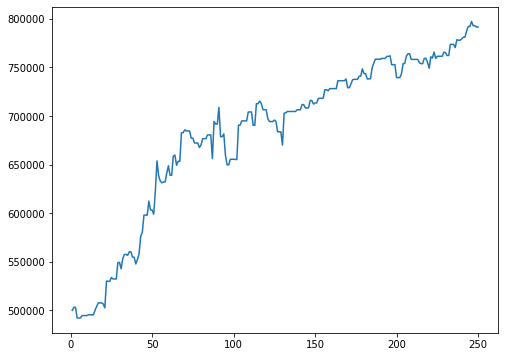

In [3]:
#一阶对称模型4：做多时，如果前一天收盘价小于标准价，就按开盘价交易，如果前一天收盘价大于明天标准价，那就只有触发标准线才做交易

TC=500000       #总资金50万

C=1             #每次交易1手


leverage=10

cost_rate=0.000023


price_per_point=300       #1点300元




m=0
n=0
p=0
r=0
R=0
s=0

I=0
B=0
RR=[0]
II=[0]
BB=[0]
tt=0
t=0
d=12
d2=0

rr=[0]
maximum_markdown_final=[0]
CR=1
CRR=[0]
TCC=[0]

day=250
k=day
#for k in range(3000):
while k<=day and k>0:
    
    if k>0:
        data=np.array(features[-past_history-k:-1-k])
        data2=np.array(features.iloc[-1-k])
        data=np.vstack((data,data2))

        
        t+=1 
        
        tt=np.vstack((tt,t))
        
        
        #print(data2)

        #j=[0,0,0,0,0]
        j=[0]
        
        for i in data:
            i=np.array([i])
            j=np.vstack((j,i))
        #print(j.shape)

        j=j[1:past_history+1]
        #print(j.shape)
        j=[j]
        
        
        
        
        
        
        #data.reshape((240,1))
        #print(data.shape)
        data=tf.convert_to_tensor(j)
        #print(data)



        x=np.array(single_step_model.predict(data))

        #trend=x[0][0]-MV[-1-k]-MV[-2-k]                #预测正负
        
        #trend_real=MV[-k]-MV[-1-k]-MV[-2-k]           #实际正负
        
        #P0=np.array(df['C'])[-7-k]
        #P1=np.array(df['C'])[-6-k]
        #P2=np.array(df['C'])[-5-k]
        #P5=np.array(df['C'])[-2-k]
        #P6=np.array(df['C'])[-1-k]
        
        trend=x[0][0]-MV[-1-k]                #预测正负
        
        trend_real=MV[-k]-MV[-1-k]          #实际正负
        
        
        P0=np.array(df['close'])[-6-k]
        P1=np.array(df['close'])[-5-k]
        P5=np.array(df['close'])[-1-k]
        
        
        
        
        
        #line=P6+P5+P2-P1-P0
        
        line=P5+P1-P0
        
        L=np.array(df['low'])[-k]
        H=np.array(df['high'])[-k]
        
        if trend<0:
            if P5-d2>line and (np.array(df['open'])[-k])-d2>line:
                r1=((np.array(df['close'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
                maximum_markdown=((np.array(df['low'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
                
                profit1=(np.array(df['close'])[-k])*price_per_point-(np.array(df['open'])[-k])*price_per_point-(np.array(df['close'])[-k])*price_per_point*cost_rate-(np.array(df['open'])[-k])*price_per_point*cost_rate
                
                
                
                
            else:
                if L<line<H:
                    r1=((np.array(df['close'])[-k])-(line))/(line)                      #r1必须小于0 
                    maximum_markdown=((np.array(df['low'])[-k])-(line))/(line)
                    
                    profit1=(np.array(df['close'])[-k])*price_per_point-(line)*price_per_point-(np.array(df['close'])[-k])*price_per_point*cost_rate-(line)*price_per_point*cost_rate
                    
                    
                else:
                    r1=0
                    maximum_markdown=0
                    profit1=0
                    
                    
            print("r1=",r1)
            
            if r1!=0:
                m+=1
                
            
            if r1<0:
                n+=1
            r=r+r1
            R=R+r1
            
        else:
            r1=0
            r=r
            R=R
            maximum_markdown=0
            profit1=0
            
        
        if trend>0:
            
            
            if P5<line-d and (np.array(df['open'])[-k])<line-d:
                r2=((np.array(df['close'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
                maximum_markdown=((np.array(df['low'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
                
                profit2=(np.array(df['close'])[-k])*price_per_point-(np.array(df['open'])[-k])*price_per_point-(np.array(df['close'])[-k])*price_per_point*cost_rate-(np.array(df['open'])[-k])*price_per_point*cost_rate
                
                
                
                
            else:
                if L<line<H:
                    r2=((np.array(df['close'])[-k])-(line))/(line)    #r2必须大于0 
                    maximum_markdown=((np.array(df['low'])[-k])-(line))/(line)
                    
                    profit2=(np.array(df['close'])[-k])*price_per_point-(line)*price_per_point-(np.array(df['close'])[-k])*price_per_point*cost_rate-(line)*price_per_point*cost_rate
                else:
                    r2=0
                    maximum_markdown=0
                    profit2=0
                    
            print("r2=",r2)
            
            if r2!=0:
                m+=1
                s+=1
            
            if r2>0:
                p+=1
            R=R+r2
        else:
            R=R
            r2=0
            maximum_markdown=0
            profit2=0
            
            
        TC=TC+profit1+profit2
        TCC=np.vstack((TCC,TC))
        
        i=((np.array(df['close'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
        I=I+i
        
        b=((np.array(df['close'])[-k])-(np.array(df['close'])[-k-1]))/(np.array(df['close'])[-k-1])
        B=B+b
        
        
        BB=np.vstack((BB,B))
        RR=np.vstack((RR,R))  
        II=np.vstack((II,I))
        
        maximum_markdown_final=np.vstack((maximum_markdown_final,maximum_markdown))
        rr=np.vstack((rr,r2))
        
        if r1!=0:
            CR=CR*(1+r1)
        else:
            CR=CR
        if r2!=0:
            CR=CR*(1+r1)
        else:
            CR=CR
        
        CRR=np.vstack((CRR,(CR-1)*10))
    k=k-1
    
    

    
    
    
RR=RR[1:]
II=II[1:]
tt=tt[1:]

TCC=TCC[1:]



#plt.plot(tt,RR)               
#plt.plot(tt,II) 
plt.plot(tt,TCC) 



  
maximum_markdown_final=maximum_markdown_final[1:]        
#plt.plot(tt,maximum_markdown_final)  
final_maximum=min(maximum_markdown_final)
rr=rr[1:]
maximum_loss=min(rr) 

     
print("trading dates=",m)
print("success to sell=",n)
print("success to buy=",p)
print('负趋势收益=',r)
print('做多总收益=',R)
print('正趋势做多的次数',s)      
print('总体策略日中最大回撤=',final_maximum)
print('正趋势日中做多最大亏损=',maximum_loss)
print('正趋势日平均收益=',np.mean(rr))
print('最终复利=',CR-1)

print("最后总资金=",TC)



#CRR=CRR[1:]
#plt.plot(tt,CRR)
BB=BB[1:]
#plt.plot(tt,BB)



data=np.array(features[-past_history:-1])
data2=np.array(features.iloc[-1])
data=np.vstack((data,data2))

j=[0]
        
for i in data:
    i=np.array([i])
    j=np.vstack((j,i))
    

j=j[1:past_history+1]
        
j=[j]
        

data=tf.convert_to_tensor(j)
x=np.array(single_step_model.predict(data))

trend=x[0][0]-MV[-1]                
        
  
P0=np.array(df['close'])[-6]
P1=np.array(df['close'])[-5]
P5=np.array(df['close'])[-1]

line=P5+P1-P0

if trend>0:
    print("明天收盘价>",line,'概率为',p/s)
    
    
    
else:
    print("明天收盘价<",line,'概率为',1-n/(m-s))     #这是沪深300的每日判断
    

if trend>0 and P5<line-d:
    print('前一天收盘价已经小于标准价了，当开盘价也小于标准价',line,"减去12个点,即为",line-12,"时，请在开盘时间做多，同时挂一个收盘的空单")
    
elif trend>0:
    print('明天请在标准价',line,'挂一个多单，如果触发了标准价，请在收盘价挂一个空单')
    
    if P5>=line-d and line>P5:
        print('如果触发了标准价，请按开盘价的价格挂一个多单，如果触发了开盘价的多单，再在收盘挂多一个空单')
    
elif trend<0:
    if P5-d2>line and (np.array(df['open'])[-k])-d2>line:
        print("如果明天开盘价大于",line+d2,'请在开盘时间做多，同时挂一个收盘的空单')
    else:
        print('明天请在标准价',line,'挂一个多单，如果触发了标准价,即价格>=',line,'请在收盘价挂一个空单')
    

date: 2015-11-09 买入价= 3796.38 卖出价= 3840.35 盈利= 13138.306563
date: 2015-11-10 买入价= 3829.88 卖出价= 3833.24 盈利= 955.1244720000001
date: 2015-11-11 没有触及交易 盈利= 0
date: 2015-11-12 没有触及交易 盈利= 0
date: 2015-11-13 没有触及交易 盈利= 0
date: 2015-11-16 没有触及交易 盈利= 0
date: 2015-11-17 买入价= 3757.02 卖出价= 3758.39 盈利= 359.14367100000004
date: 2015-11-18 买入价= 3758.8 卖出价= 3715.58 盈利= -13017.573221999999
date: 2015-11-19 没有触及交易 盈利= 0
date: 2015-11-20 没有触及交易 盈利= 0
date: 2015-11-23 买入价= 3792.2700000000004 卖出价= 3753.33 盈利= -11734.064640000233
date: 2015-11-24 买入价= 3747.5899999999992 卖出价= 3753.89 盈利= 1838.2397880002327
date: 2015-11-25 没有触及交易 盈利= 0
date: 2015-11-26 没有触及交易 盈利= 0
date: 2015-11-27 没有触及交易 盈利= 0
date: 2015-11-30 买入价= 3535.9399999999996 卖出价= 3566.41 盈利= 9091.993785000233
date: 2015-12-01 买入价= 3566.9699999999993 卖出价= 3591.7 盈利= 7369.605177000233
date: 2015-12-02 买入价= 3587.76 卖出价= 3721.96 盈利= 40209.562932
date: 2015-12-03 买入价= 3699.7799999999993 卖出价= 3749.3 盈利= 14804.601348000233
date: 2015-12-04 没有触及交易 盈利= 0
d

date: 2016-07-12 买入价= 3206.01 卖出价= 3273.18 盈利= 20106.29358899988
date: 2016-07-13 买入价= 3282.5999999999995 卖出价= 3282.87 盈利= 35.69825700011641
date: 2016-07-14 买入价= 3277.48 卖出价= 3276.76 盈利= -261.2242559998836
date: 2016-07-15 买入价= 3278.83 卖出价= 3276.28 盈利= -810.2302589998835
date: 2016-07-18 没有触及交易 盈利= 0
date: 2016-07-19 没有触及交易 盈利= 0
date: 2016-07-20 没有触及交易 盈利= 0
date: 2016-07-21 没有触及交易 盈利= 0
date: 2016-07-22 买入价= 3252.04 卖出价= 3225.16 盈利= -8108.69268
date: 2016-07-25 没有触及交易 盈利= 0
date: 2016-07-26 没有触及交易 盈利= 0
date: 2016-07-27 买入价= 3270.08 卖出价= 3218.24 盈利= -15596.769408000117
date: 2016-07-28 买入价= 3204.46 卖出价= 3221.14 盈利= 4959.6633600000005
date: 2016-07-29 没有触及交易 盈利= 0
date: 2016-08-01 没有触及交易 盈利= 0
date: 2016-08-02 买入价= 3173.76 卖出价= 3189.05 盈利= 4543.096610999884
date: 2016-08-03 没有触及交易 盈利= 0
date: 2016-08-04 买入价= 3196.41 卖出价= 3201.29 盈利= 1419.8558699999999
date: 2016-08-05 没有触及交易 盈利= 0
date: 2016-08-08 没有触及交易 盈利= 0
date: 2016-08-09 买入价= 3246.4199999999996 卖出价= 3256.98 盈利= 3123.12654000011

date: 2017-03-13 买入价= 3425.67 卖出价= 3458.1 盈利= 9681.501987
date: 2017-03-14 没有触及交易 盈利= 0
date: 2017-03-15 买入价= 3451.46 卖出价= 3463.64 盈利= 3606.28581
date: 2017-03-16 买入价= 3472.27 卖出价= 3481.51 盈利= 2724.0189180001166
date: 2017-03-17 买入价= 3482.4599999999996 卖出价= 3445.81 盈利= -11042.805062999885
date: 2017-03-20 没有触及交易 盈利= 0
date: 2017-03-21 买入价= 3448.2000000000003 卖出价= 3466.35 盈利= 5397.2896049998835
date: 2017-03-22 没有触及交易 盈利= 0
date: 2017-03-23 买入价= 3452.41 卖出价= 3461.98 盈利= 2823.290709
date: 2017-03-24 没有触及交易 盈利= 0
date: 2017-03-27 买入价= 3493.4 卖出价= 3478.04 盈利= -4656.102935999999
date: 2017-03-28 没有触及交易 盈利= 0
date: 2017-03-29 买入价= 3472.97 卖出价= 3465.19 盈利= -2381.873303999884
date: 2017-03-30 没有触及交易 盈利= 0
date: 2017-03-31 买入价= 3434.82 卖出价= 3456.05 盈利= 6321.452997
date: 2017-04-05 没有触及交易 盈利= 0
date: 2017-04-06 买入价= 3507.99 卖出价= 3514.05 盈利= 1769.547924
date: 2017-04-07 买入价= 3514.45 卖出价= 3517.46 盈利= 854.479821
date: 2017-04-10 买入价= 3519.46 卖出价= 3505.14 盈利= -4344.46974
date: 2017-04-11 没有触及交易 盈利= 

date: 2017-11-08 买入价= 4051.49 卖出价= 4048.01 盈利= -1099.88655
date: 2017-11-09 买入价= 4048.5200000000004 卖出价= 4075.9 盈利= 8157.941501999768
date: 2017-11-10 买入价= 4071.4700000000003 卖出价= 4111.91 盈利= 12075.534678
date: 2017-11-13 没有触及交易 盈利= 0
date: 2017-11-14 没有触及交易 盈利= 0
date: 2017-11-15 买入价= 4093.1100000000006 卖出价= 4073.67 盈利= -5888.350782000233
date: 2017-11-16 买入价= 4101.5599999999995 卖出价= 4105.01 盈利= 978.3746670002329
date: 2017-11-17 没有触及交易 盈利= 0
date: 2017-11-20 买入价= 4137.01 卖出价= 4143.83 盈利= 1988.862204
date: 2017-11-21 买入价= 4131.85 卖出价= 4217.7 盈利= 25697.388105
date: 2017-11-22 买入价= 4228.37 卖出价= 4227.57 盈利= -298.345986
date: 2017-11-23 没有触及交易 盈利= 0
date: 2017-11-24 没有触及交易 盈利= 0
date: 2017-11-27 买入价= 4088.93 卖出价= 4049.95 盈利= -11750.158271999999
date: 2017-11-28 没有触及交易 盈利= 0
date: 2017-11-29 买入价= 4065.6899999999996 卖出价= 4053.75 盈利= -3638.024135999767
date: 2017-11-30 没有触及交易 盈利= 0
date: 2017-12-01 买入价= 4007.8999999999996 卖出价= 3998.14 盈利= -2983.2416759999996
date: 2017-12-04 没有触及交易 盈利= 0
dat

date: 2018-07-12 买入价= 3403.33 卖出价= 3481.06 盈利= 23271.497709
date: 2018-07-13 没有触及交易 盈利= 0
date: 2018-07-16 没有触及交易 盈利= 0
date: 2018-07-17 没有触及交易 盈利= 0
date: 2018-07-18 没有触及交易 盈利= 0
date: 2018-07-19 没有触及交易 盈利= 0
date: 2018-07-20 买入价= 3439.9700000000007 卖出价= 3492.89 盈利= 15828.163265999767
date: 2018-07-23 买入价= 3472.2899999999995 卖出价= 3525.75 盈利= 15989.713524000115
date: 2018-07-24 买入价= 3530.66 卖出价= 3581.71 盈利= 15265.924647000002
date: 2018-07-25 买入价= 3589.51 卖出价= 3577.75 盈利= -3577.454094
date: 2018-07-26 买入价= 3583.32 卖出价= 3536.25 盈利= -14170.125033
date: 2018-07-27 没有触及交易 盈利= 0
date: 2018-07-30 没有触及交易 盈利= 0
date: 2018-07-31 没有触及交易 盈利= 0
date: 2018-08-01 买入价= 3530.03 卖出价= 3447.39 盈利= -24840.144198
date: 2018-08-02 买入价= 3405.8899999999994 卖出价= 3370.96 盈利= -10525.760264999768
date: 2018-08-03 买入价= 3355.9400000000005 卖出价= 3315.28 盈利= -12244.031418
date: 2018-08-06 买入价= 3309.1300000000006 卖出价= 3273.27 盈利= -10803.418560000116
date: 2018-08-07 买入价= 3275.8500000000004 卖出价= 3368.87 盈利= 27860.151431

date: 2019-03-18 买入价= 3753.64 卖出价= 3851.75 盈利= 29380.522809
date: 2019-03-19 没有触及交易 盈利= 0
date: 2019-03-20 买入价= 3825.34 卖出价= 3835.44 盈利= 2977.140618
date: 2019-03-21 买入价= 3840.28 卖出价= 3836.89 盈利= -1069.972473
date: 2019-03-22 没有触及交易 盈利= 0
date: 2019-03-25 没有触及交易 盈利= 0
date: 2019-03-26 买入价= 3725.04 卖出价= 3700.44 盈利= -7431.235812
date: 2019-03-27 没有触及交易 盈利= 0
date: 2019-03-28 买入价= 3744.8399999999997 卖出价= 3728.4 盈利= -4983.565356
date: 2019-03-29 没有触及交易 盈利= 0
date: 2019-04-01 没有触及交易 盈利= 0
date: 2019-04-02 买入价= 3986.34 卖出价= 3971.29 盈利= -4569.907647
date: 2019-04-03 买入价= 4014.2400000000002 卖出价= 4022.16 盈利= 2320.54884
date: 2019-04-04 买入价= 4039.74 卖出价= 4062.23 盈利= 6691.096407
date: 2019-04-08 没有触及交易 盈利= 0
date: 2019-04-09 没有触及交易 盈利= 0
date: 2019-04-10 买入价= 4072.7899999999995 卖出价= 4085.85 盈利= 3861.705384000233
date: 2019-04-11 没有触及交易 盈利= 0
date: 2019-04-12 没有触及交易 盈利= 0
date: 2019-04-15 买入价= 4056.49 卖出价= 3975.52 盈利= -24346.420869
date: 2019-04-16 买入价= 3958.1 卖出价= 4085.79 盈利= 38251.497159
date: 2

date: 2019-11-29 买入价= 3822.69 卖出价= 3828.67 盈利= 1741.205616
date: 2019-12-02 买入价= 3835.51 卖出价= 3836.06 盈利= 112.066167
date: 2019-12-03 买入价= 3829.21 卖出价= 3851.09 盈利= 6511.00593
date: 2019-12-04 买入价= 3835.06 卖出价= 3849.82 盈利= 4374.974327999999
date: 2019-12-05 没有触及交易 盈利= 0
date: 2019-12-06 买入价= 3885.06 卖出价= 3902.39 盈利= 5145.266595
date: 2019-12-09 买入价= 3909.7799999999997 卖出价= 3895.45 盈利= -4352.856087
date: 2019-12-10 没有触及交易 盈利= 0
date: 2019-12-11 买入价= 3907.16 卖出价= 3902.75 盈利= -1376.888379
date: 2019-12-12 没有触及交易 盈利= 0
trading dates= 563
success to sell= 138
success to buy= 156
负趋势收益= 0.32907344131079164
做多总收益= 0.930926725175896
正趋势做多的次数 253
总体策略日中最大回撤= [-0.05321654]
正趋势日中做多最大亏损= [-0.05132598]
正趋势日平均收益= 0.0006018532838651046
最终复利= 0.3730817799140582
最后总资金= 1423828.588298001


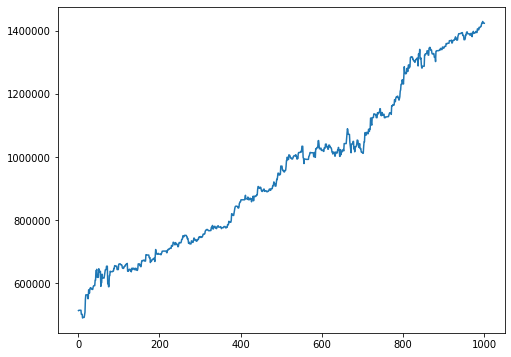

In [19]:
#一阶对称模型4：做多时，如果前一天收盘价小于标准价，就按开盘价交易，如果前一天收盘价大于明天标准价，那就只有触发标准线才做交易

TC=500000       #总资金50万

C=1             #每次交易1手


leverage=10

cost_rate=0.000023


price_per_point=300       #1点300元




m=0
n=0
p=0
r=0
R=0
s=0

I=0
B=0
RR=[0]
II=[0]
BB=[0]
tt=0
t=0
d=12
d2=0

rr=[0]
maximum_markdown_final=[0]
CR=1
CRR=[0]
TCC=[0]

day=1000
k=day
#for k in range(3000):
while k<=day and k>0:
    
    if k>0:
        data=np.array(features[-past_history-k:-1-k])
        data2=np.array(features.iloc[-1-k])
        data=np.vstack((data,data2))

        
        t+=1 
        
        tt=np.vstack((tt,t))
        
        
        #print(data2)

        #j=[0,0,0,0,0]
        j=[0]
        
        for i in data:
            i=np.array([i])
            j=np.vstack((j,i))
        #print(j.shape)

        j=j[1:past_history+1]
        #print(j.shape)
        j=[j]
        
        
        
        
        
        
        #data.reshape((240,1))
        #print(data.shape)
        data=tf.convert_to_tensor(j)
        #print(data)



        x=np.array(single_step_model.predict(data))

        #trend=x[0][0]-MV[-1-k]-MV[-2-k]                #预测正负
        
        #trend_real=MV[-k]-MV[-1-k]-MV[-2-k]           #实际正负
        
        #P0=np.array(df['C'])[-7-k]
        #P1=np.array(df['C'])[-6-k]
        #P2=np.array(df['C'])[-5-k]
        #P5=np.array(df['C'])[-2-k]
        #P6=np.array(df['C'])[-1-k]
        
        trend=x[0][0]-MV[-1-k]                #预测正负
        
        trend_real=MV[-k]-MV[-1-k]          #实际正负
        
        
        P0=np.array(df['close'])[-6-k]
        P1=np.array(df['close'])[-5-k]
        P5=np.array(df['close'])[-1-k]
        
        
        
        
        
        #line=P6+P5+P2-P1-P0
        
        line=P5+P1-P0
        
        L=np.array(df['low'])[-k]
        H=np.array(df['high'])[-k]
        
        if trend<0:
            if P5-d2>line and (np.array(df['open'])[-k])-d2>line:
                r1=((np.array(df['close'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
                maximum_markdown=((np.array(df['low'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
                
                profit1=(np.array(df['close'])[-k])*price_per_point-(np.array(df['open'])[-k])*price_per_point-(np.array(df['close'])[-k])*price_per_point*cost_rate-(np.array(df['open'])[-k])*price_per_point*cost_rate
                
                print('date:',df['date'][len(df['date'])-k],'买入价=',(np.array(df['open'])[-k]),"卖出价=",(np.array(df['close'])[-k]),'盈利=',profit1)
                
                
            else:
                if L<line<H:
                    r1=((np.array(df['close'])[-k])-(line))/(line)                      #r1必须小于0 
                    maximum_markdown=((np.array(df['low'])[-k])-(line))/(line)
                    
                    profit1=(np.array(df['close'])[-k])*price_per_point-(line)*price_per_point-(np.array(df['close'])[-k])*price_per_point*cost_rate-(line)*price_per_point*cost_rate
                    print('date:',df['date'][len(df['date'])-k],'买入价=',(line),"卖出价=",(np.array(df['close'])[-k]),'盈利=',profit1)
                    
                else:
                    r1=0
                    maximum_markdown=0
                    profit1=0
                    
                    print('date:',df['date'][len(df['date'])-k],'没有触及交易','盈利=',0)
            
            
            if r1!=0:
                m+=1
                
            
            if r1<0:
                n+=1
            r=r+r1
            R=R+r1
            
        else:
            r1=0
            r=r
            R=R
            maximum_markdown=0
            profit1=0
            
        
        if trend>0:
            
            
            if P5<line-d and (np.array(df['open'])[-k])<line-d:
                r2=((np.array(df['close'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
                maximum_markdown=((np.array(df['low'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
                
                profit2=(np.array(df['close'])[-k])*price_per_point-(np.array(df['open'])[-k])*price_per_point-(np.array(df['close'])[-k])*price_per_point*cost_rate-(np.array(df['open'])[-k])*price_per_point*cost_rate
                
                print('date:',df['date'][len(df['date'])-k],'买入价=',(np.array(df['open'])[-k]),"卖出价=",(np.array(df['close'])[-k]),'盈利=',profit2)
                
                
            else:
                if L<line<H:
                    r2=((np.array(df['close'])[-k])-(line))/(line)    #r2必须大于0 
                    maximum_markdown=((np.array(df['low'])[-k])-(line))/(line)
                    
                    profit2=(np.array(df['close'])[-k])*price_per_point-(line)*price_per_point-(np.array(df['close'])[-k])*price_per_point*cost_rate-(line)*price_per_point*cost_rate
                    
                    print('date:',df['date'][len(df['date'])-k],'买入价=',(line),"卖出价=",(np.array(df['close'])[-k]),'盈利=',profit2)
                    
                else:
                    r2=0
                    maximum_markdown=0
                    profit2=0
                    
                    print('date:',df['date'][len(df['date'])-k],'没有触及交易','盈利=',0)
            
            
            if r2!=0:
                m+=1
                s+=1
            
            if r2>0:
                p+=1
            R=R+r2
        else:
            R=R
            r2=0
            maximum_markdown=0
            profit2=0
            
            
        TC=TC+profit1+profit2
        TCC=np.vstack((TCC,TC))
        
        i=((np.array(df['close'])[-k])-(np.array(df['open'])[-k]))/(np.array(df['open'])[-k])
        I=I+i
        
        b=((np.array(df['close'])[-k])-(np.array(df['close'])[-k-1]))/(np.array(df['close'])[-k-1])
        B=B+b
        
        
        BB=np.vstack((BB,B))
        RR=np.vstack((RR,R))  
        II=np.vstack((II,I))
        
        maximum_markdown_final=np.vstack((maximum_markdown_final,maximum_markdown))
        rr=np.vstack((rr,r2))
        
        if r1!=0:
            CR=CR*(1+r1)
        else:
            CR=CR
        if r2!=0:
            CR=CR*(1+r1)
        else:
            CR=CR
        
        CRR=np.vstack((CRR,(CR-1)*10))
    k=k-1
    
    

    
    
    
RR=RR[1:]
II=II[1:]
tt=tt[1:]

TCC=TCC[1:]



#plt.plot(tt,RR)               
#plt.plot(tt,II) 
plt.plot(tt,TCC) 



  
maximum_markdown_final=maximum_markdown_final[1:]        
#plt.plot(tt,maximum_markdown_final)  
final_maximum=min(maximum_markdown_final)
rr=rr[1:]
maximum_loss=min(rr) 

     
print("trading dates=",m)
print("success to sell=",n)
print("success to buy=",p)
print('负趋势收益=',r)
print('做多总收益=',R)
print('正趋势做多的次数',s)      
print('总体策略日中最大回撤=',final_maximum)
print('正趋势日中做多最大亏损=',maximum_loss)
print('正趋势日平均收益=',np.mean(rr))
print('最终复利=',CR-1)

print("最后总资金=",TC)



#CRR=CRR[1:]
#plt.plot(tt,CRR)
BB=BB[1:]
#plt.plot(tt,BB)



